In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from nanonets.topology import NanoparticleTopology
from nanonets.electrostatic import NanoparticleElectrostatic

def display_packed_structure(pos_after, radius_vals):
    
    fig = plt.figure()
    ax  = fig.add_subplot()
    bou = np.max(np.abs(np.array(list(pos_after.values())))) + np.max(radius_vals)
    for key, val in pos_after.items():
        if key >= 0:
            circle_ = plt.Circle((val[0],val[1]),radius_vals[key])
        else:
            circle_ = plt.Circle((val[0],val[1]),10.0)
        ax.add_patch(circle_)
    ax.set_aspect('equal')
    ax.set_xlim(-bou*1.2, bou*1.2)
    ax.set_ylim(-bou*1.2, bou*1.2)
    ax.axis('off')

### Lattice

In [2]:
sim_c       = NanoparticleElectrostatic()
L           = 9
N_e         = 8
e_pos       = [[0,0], [int((L-1)/2),0],[L-1,0], [0,int((L-1)/2)],[0,L-1],[L-1,int((L)/2)],[int((L)/2),(L-1)],[L-1,L-1]]
mean_r1     = 10.0

sim_c.lattice_network(L, L)
sim_c.add_electrodes_to_lattice_net(e_pos)
sim_c.init_nanoparticle_radius(mean_r1)
radius_vals = sim_c.get_radius()
pos_before  = sim_c.get_positions()
sim_c.pack_lattice()
pos_after   = sim_c.get_positions()

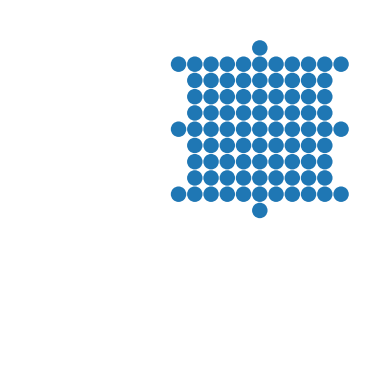

In [3]:
display_packed_structure(pos_after, radius_vals)

### Disorderd Network / Fixed Radius

In [22]:
def create_packing_graph(positions, radii, d_min, delta):
    """
    Creates a directed graph from circle packing positions.
    Nodes are connected if their physical distance is within a tolerance range.
    
    Args:
        positions (dict): {index: [x, y]} output from the packing function.
        radii (array-like): List of radii corresponding to indices.
        d_min (float): The minimum buffer used in packing.
        delta (float): Connection tolerance. 
                       Two particles connect if dist < (r_i + r_j + d_min + delta).
                       
    Returns:
        nx.DiGraph: A directed graph with N nodes.
    """
    N = len(radii)
    G = nx.DiGraph()
    
    # 1. Add all nodes explicitly (in case some have no connections)
    # We can store attributes like position and radius in the node for later use
    for i in range(N):
        G.add_node(i, pos=positions[i], radius=radii[i])
    
    # 2. Check all pairs for connections
    # We loop j > i to avoid duplicate checks, then add edges in both directions
    for i in range(N):
        pos_i = np.array(positions[i])
        r_i = radii[i]
        
        for j in range(i + 1, N):
            pos_j = np.array(positions[j])
            r_j = radii[j]
            
            # Calculate Euclidean distance
            dist = np.linalg.norm(pos_i - pos_j)
            
            # The Connection Condition
            # "Touching" logic: Sum of radii + Buffer + Tolerance
            contact_threshold = r_i + r_j + d_min + delta
            
            if dist <= contact_threshold:
                # Add directed edges both ways (symmetric connection)
                G.add_edge(i, j)
                G.add_edge(j, i)
                
    return G

def add_electrodes_docked(G, positions, radii, electrode_config, d_min, electrode_radius=0.5):
    """
    Adds electrodes by identifying a target direction (e.g. "top-right") and 
    'docking' the electrode onto the nearest particle at exactly d_min distance.

    Algorithm:
    1. Calculate an 'initial target' far outside the cluster based on electrode_config.
    2. Find the nearest existing particle to this target.
    3. Define a line between that particle's center and the target.
    4. Place the electrode along this line such that the gap is exactly d_min.

    Parameters
    ----------
    G : nx.DiGraph
        The existing device graph (modified in-place).
    positions : dict
        Particle positions {index: [x, y]} (modified in-place).
    radii : array_like
        Existing particle radii.
    electrode_config : list of lists
        Normalized direction vectors [[-1, -1], [1, 0], ...].
    d_min : float
        The required separation distance.
    electrode_radius : float, optional
        Radius of the electrode nodes. Default is 0.5.
    """
    # 1. Determine the "Horizon" (Initial Target Distance)
    # We place the initial targets far out to ensure we pick the correct "surface" particle.
    coords = np.array(list(positions.values()))
    existing_indices = np.array(list(positions.keys()))
    
    # Max extent of the current device
    max_r = np.max(radii)
    # Go significantly further out (e.g., 2.0x limit) to define the "direction" clearly
    device_limit = np.max(np.abs(coords)) * 2.0 + max_r
    
    used_particles = set()
    
    for i, config_vec in enumerate(electrode_config):
        # A. Define the Directional Target (The "Lighthouse")
        # Map [-1, 1] to a position far outside the cluster
        direction_vec = np.array(config_vec, dtype=float)
        
        # Handle case where direction is [0,0] (invalid)
        if np.linalg.norm(direction_vec) == 0:
            raise ValueError(f"Invalid electrode config {config_vec}: cannot be [0,0]")
            
        initial_target_pos = direction_vec * device_limit
        
        # B. Find the 'Surface' Particle
        # Which particle is closest to this distant target?
        dists = np.linalg.norm(coords - initial_target_pos, axis=1)
        
        # Get candidate particles sorted by distance to target
        sorted_idx = np.argsort(dists)
        
        found_particle = None
        for idx in sorted_idx:
            real_idx = existing_indices[idx]
            if real_idx not in used_particles:
                found_particle = real_idx
                used_particles.add(real_idx)
                break
        
        if found_particle is None:
            raise RuntimeError("No free particles available for electrode attachment.")
            
        # C. Calculate Docking Position
        p_pos = np.array(positions[found_particle])
        p_radius = radii[found_particle]
        
        # Vector from Particle -> Target
        vec_to_target = initial_target_pos - p_pos
        dist_to_target = np.linalg.norm(vec_to_target)
        
        if dist_to_target == 0:
            # Should not happen given our device_limit logic, but safety first
            direction_unit = np.array([1.0, 0.0])
        else:
            direction_unit = vec_to_target / dist_to_target
            
        # The required distance from particle center to electrode center
        # r_particle + r_electrode + d_min
        docking_distance = p_radius + electrode_radius + d_min
        
        # The new precise position
        final_pos = p_pos + direction_unit * docking_distance
        
        # D. Add to Graph
        electrode_id = -(i + 1) # -1, -2, etc.
        
        G.add_node(electrode_id, pos=final_pos.tolist(), radius=electrode_radius, type='electrode')
        
        # Bi-directional connection
        G.add_edge(electrode_id, found_particle)
        G.add_edge(found_particle, electrode_id)
        
        # Store position
        positions[electrode_id] = final_pos.tolist()

In [25]:
sim_c       = NanoparticleElectrostatic()
N_p         = 81
N_e         = 8
e_pos       = [[-1,-1],[0,-1],[1,-1],[-1,0],[1,0],[-1,1],[0,1],[1,1]]
mean_r1     = 10.0

sim_c.random_network(N_p)
sim_c.add_electrodes_to_random_net(e_pos)
sim_c.init_nanoparticle_radius(mean_r1)
radius_vals = sim_c.get_radius()
pos_before  = sim_c.get_positions()
sim_c.pack_circles()
sim_c.create_packing_graph()
pos_after   = sim_c.get_positions()
G_after     = sim_c.get_graph()

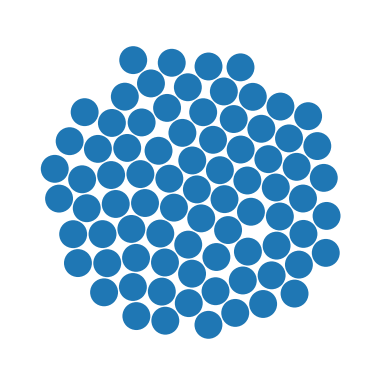

In [26]:
display_packed_structure(pos_after, radius_vals)

In [27]:
add_electrodes_docked(G_after, pos_after, radius_vals, e_pos, 1.0, 10.0)

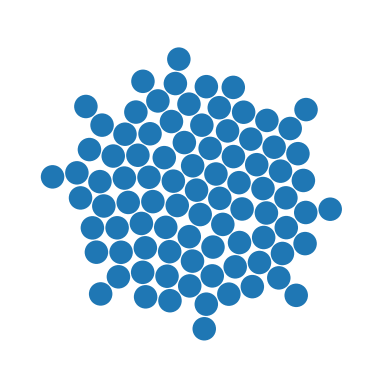

In [28]:
display_packed_structure(pos_after, radius_vals)

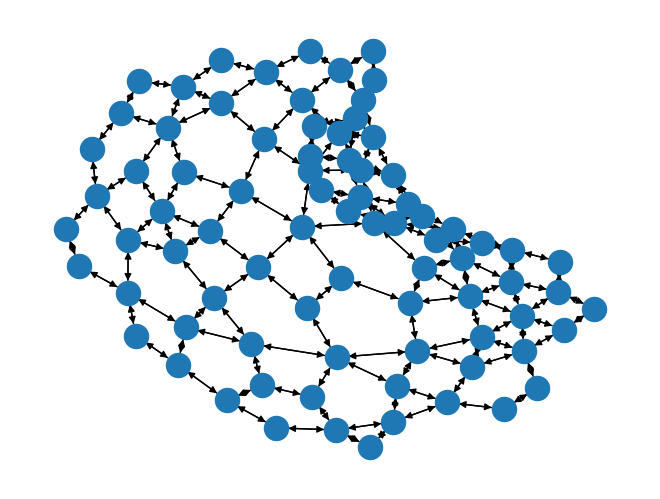

In [8]:
nx.draw(G_after)

### Disorderd Network / Radius Disorder

In [ ]:
# Network Params
sim_c       = NanoparticleElectrostatic()
N_p         = 81
N_e         = 8
e_pos       = [[-1,-1],[0,-1],[1,-1],[-1,0],[1,0],[-1,1],[0,1],[1,1]]
mean_r1     = 10.0
mean_r2     = 80.0
N_mean_r2   = N_p // 3

# Packing Params
initial_temp = 0.0
k_attract    = 0.1
start_cutoff = 100.0
iterations   = 20000

sim_c.random_network(N_p)
sim_c.add_electrodes_to_random_net(e_pos)
sim_c.init_nanoparticle_radius(mean_r1)
sim_c.update_nanoparticle_radius_at_random(N_mean_r2, mean_r2)
radius_vals = sim_c.get_radius()
pos_before  = sim_c.get_positions()
sim_c.pack_circles(iterations=iterations, initial_temp=initial_temp, k_attract=k_attract, start_cutoff=start_cutoff)
pos_after   = sim_c.get_positions()

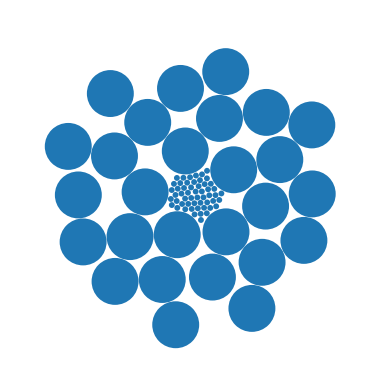

In [13]:
display_packed_structure(pos_after, radius_vals)

In [ ]:
add_electrodes()

TypeError: 'dict' object is not callable